In [1]:
import pandas as pd

# 加载数据集
data = pd.read_csv('data.csv')
print(data.head())

   Unnamed: 0      id  score  votes  year  TV  剧场版  漫画改  搞笑  原创  ...  喵帕斯  \
0           0  328561    7.0      2  2000   0    0    0   0   0  ...    0   
1           1   28389    7.2    630  2000  86    0    0   0   6  ...    0   
2           2   22956    6.3    198  2000   0    0   29   0   0  ...    0   
3           3  112705    6.7      6  2000   0    1    0   2   0  ...    0   
4           4  186592    6.9     17  2000   0    3    2   0   0  ...    0   

   户松遥  山本宽  萌系  嘟嘟噜  SOS团  少女系  ZEXCS  Air  宅  
0    0    0   0    0     0    0      0    0  0  
1    0    0   0    0     0    0      0    0  0  
2    0    0   0    0     0    0      0    0  0  
3    0    0   0    0     0    0      0    0  0  
4    0    0   0    0     0    0      0    0  0  

[5 rows x 408 columns]


In [2]:
# 对 'score' 进行正则化
data['score'] = data['score'] / 10.0

# 对 'votes' 使用最大值进行标准化
votes_max = data['votes'].max()
data['votes'] = data['votes'] / votes_max

# 对年份进行 Min-Max Scaling 正则化
year_min = data['year'].min()
year_max = data['year'].max()
data['year'] = (data['year'] - year_min) / (year_max - year_min)

# 对标签进行正则化 - 使用每列的最大值进行标准化
for column in data.columns[5:]:  # 假设从第六列开始为标签列
    max_value = data[column].max()
    if max_value > 0:
        data[column] = data[column] / max_value

# 显示正则化后的数据集的前几行
print(data.head())

   Unnamed: 0      id  score     votes  year        TV       剧场版       漫画改  \
0           0  328561   0.70  0.000081   0.0  0.000000  0.000000  0.000000   
1           1   28389   0.72  0.025361   0.0  0.050146  0.000000  0.000000   
2           2   22956   0.63  0.007971   0.0  0.000000  0.000000  0.012603   
3           3  112705   0.67  0.000242   0.0  0.000000  0.000218  0.000000   
4           4  186592   0.69  0.000684   0.0  0.000000  0.000653  0.000869   

         搞笑        原创  ...  喵帕斯  户松遥  山本宽   萌系  嘟嘟噜  SOS团  少女系  ZEXCS  Air  \
0  0.000000  0.000000  ...  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0   
1  0.000000  0.001646  ...  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0   
2  0.000000  0.000000  ...  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0   
3  0.000484  0.000000  ...  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0   
4  0.000000  0.000000  ...  0.0  0.0  0.0  0.0  0.0   0.0  0.0    0.0  0.0   

     宅  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  

[5 rows

In [3]:
from sklearn.model_selection import train_test_split

X, y = data.iloc[:, 4:], data.iloc[:, 2:4]
# X 和 y 已经被定义为特征和目标
# 分割比例：训练集80%，验证集10%，测试集10%

# 首先，分割出训练集（80%）
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# 接着，将剩余的20%数据再分为验证集和测试集（各占原始数据集的10%）
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 现在，X_train, y_train 是训练集
# X_val, y_val 是验证集
# X_test, y_test 是测试集

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(8949, 404) (8949, 2)
(1119, 404) (1119, 2)
(1119, 404) (1119, 2)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

class DNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # 第一个隐藏层
        self.fc2 = nn.Linear(256, 128)         # 第二个隐藏层
        self.fc3 = nn.Linear(128, 64)          # 第三个隐藏层
        self.fc4 = nn.Linear(64, 32)           # 第四个隐藏层
        self.output = nn.Linear(32, output_size)  # 输出层

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = torch.sigmoid(self.output(x))  # 应用Sigmoid激活函数
        return x

# 创建模型实例时使用动态大小
model = DNN(X_train.shape[1], y_train.shape[1])

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失，适合回归问题
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 正则化

In [6]:
num_epochs = 100  # 训练的轮数
batch_size = 128   # 批量大小

# 将 DataFrame 转换为 NumPy 数组
X_train_np = X_train.values
y_train_np = y_train.values
X_val_np = X_val.values
y_val_np = y_val.values
X_test_np = X_test.values
y_test_np = y_test.values

# 将 NumPy 数组转换为 PyTorch Tensor
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_np, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_np, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32)

# 将数据集转换为 DataLoader，以便批处理和洗牌
train_data = torch.utils.data.TensorDataset(X_train_tensor , y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
val_data = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size)
test_data = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size)

In [75]:
# 初始化损失值列表
train_loss_values = []
val_loss_values = []

patience = 10  # 容忍的无改进epoch数
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    # 训练阶段
    model.train()  # 设置模型为训练模式
    total_train_loss = 0
    for inputs, labels in train_loader:
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # 后向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_values.append(avg_train_loss)

    # 验证阶段
    model.eval()  # 设置模型为评估模式
    total_val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_values.append(avg_val_loss)

    # 检查是否有改进
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f'Early stopping: Epoch {epoch}')
        break
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}')


Epoch [1/100], Training Loss: 0.0485, Validation Loss: 0.0097
Epoch [2/100], Training Loss: 0.0091, Validation Loss: 0.0091
Epoch [3/100], Training Loss: 0.0081, Validation Loss: 0.0081
Epoch [4/100], Training Loss: 0.0075, Validation Loss: 0.0077
Epoch [5/100], Training Loss: 0.0068, Validation Loss: 0.0063
Epoch [6/100], Training Loss: 0.0055, Validation Loss: 0.0059
Epoch [7/100], Training Loss: 0.0053, Validation Loss: 0.0056
Epoch [8/100], Training Loss: 0.0050, Validation Loss: 0.0056
Epoch [9/100], Training Loss: 0.0050, Validation Loss: 0.0057
Epoch [10/100], Training Loss: 0.0050, Validation Loss: 0.0056
Epoch [11/100], Training Loss: 0.0050, Validation Loss: 0.0056
Epoch [12/100], Training Loss: 0.0049, Validation Loss: 0.0055
Epoch [13/100], Training Loss: 0.0049, Validation Loss: 0.0056
Epoch [14/100], Training Loss: 0.0048, Validation Loss: 0.0055
Epoch [15/100], Training Loss: 0.0048, Validation Loss: 0.0055
Epoch [16/100], Training Loss: 0.0048, Validation Loss: 0.0055
E

In [113]:
# # 保存 DNN 模型参数
# torch.save(model.state_dict(), 'dnn_model.pth')

In [ ]:
# # 重新创建模型实例
# model = DNN(input_size, output_size)
# # 加载之前保存的参数
# model.load_state_dict(torch.load('dnn_model.pth'))

In [118]:
# # 将验证损失保存为文本文件
# with open('dnn_train_loss.txt', 'w') as f:
#     for loss in train_loss_values:
#         f.write(f"{loss}\n")

# with open('dnn_val_loss.txt', 'w') as f:
#     for loss in val_loss_values:
#         f.write(f"{loss}\n")

In [ ]:
# # 使用文本文件加载
# with open('dnn_train_loss.txt', 'r') as f:
#     train_loss_values = [float(line.strip()) for line in f]

# with open('dnn_val_loss.txt', 'r') as f:
#     val_loss_values = [float(line.strip()) for line in f]

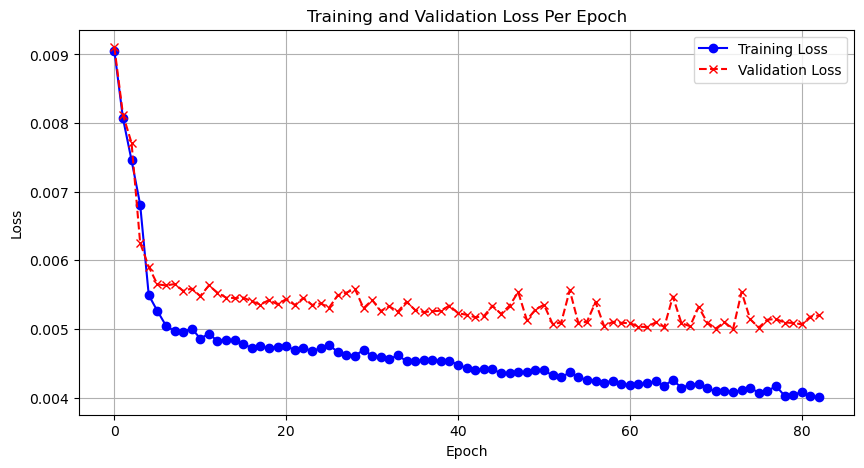

In [77]:
import matplotlib.pyplot as plt

# 绘制训练和验证损失曲线
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values[1:], label='Training Loss', marker='o', linestyle='-', color='b')
plt.plot(val_loss_values[1:], label='Validation Loss', marker='x', linestyle='--', color='r')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [78]:
# 测试模型
model.eval()  # 设置模型为评估模式
total_test_loss = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        test_loss = criterion(outputs, labels)
        total_test_loss += test_loss.item()

avg_test_loss = total_test_loss / len(test_loader)

print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 0.0048


In [7]:
import numpy as np
# 随机猜测模型
def random_guess_model(X, min_val, max_val):
    """ 对于每个输入样本随机生成两个预测值。"""
    random_predictions_1 = np.random.uniform(min_val, max_val, X.shape[0])
    random_predictions_2 = np.random.uniform(min_val, max_val, X.shape[0])
    return np.stack((random_predictions_1, random_predictions_2), axis=1)

# 计算随机猜测模型的损失
random_loss = criterion(torch.tensor(random_guess_model(X_test_np, 0, 1)), y_test_tensor)
print(f'Random Loss: {random_loss:.4f}') 

Random Loss: 0.2099


In [110]:
# 线性模型
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# 创建线性模型实例
linear_model = LinearModel(X_train.shape[1], y_train.shape[1])

# 可以使用相同的损失函数和优化器
# 如果需要，也可以为线性模型选择不同的优化器或学习率
linear_optimizer = optim.Adam(linear_model.parameters(), lr=0.001, weight_decay=1e-5)

In [111]:
num_epochs = 100  # 训练轮数
batch_size = 128   # 批量大小

# 创建数据加载器

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # 前向传播
        outputs = linear_model(inputs)
        loss = criterion(outputs, labels)

        # 后向传播和优化
        linear_optimizer.zero_grad()
        loss.backward()
        linear_optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


In [114]:
# # 保存线性模型参数
# torch.save(linear_model.state_dict(), 'linear_model.pth')

In [ ]:
# # 重新创建模型实例
# linear_model = LinearModel(input_size, output_size)

# # 加载之前保存的参数
# linear_model.load_state_dict(torch.load('linear_model.pth'))

In [112]:
linear_model.eval()  # 设置模型为评估模式
total_test_loss = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = linear_model(inputs)
        test_loss = criterion(outputs, labels)
        total_test_loss += test_loss.item()

avg_test_loss = total_test_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 0.0055
